# Practical 3 > Part 2

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10.We will mark your code based on the accuracy of your model. You should try to get at least 80% accuracy on this dataset. Don't forget to save and check in your model.

## Report
Finding the right model to use as a basline was much harder. Different models including ResNet50, DenseNet121, VGG19 were tried out. Although, ResNet50 and DenseNet121 seemed to be promising approaches in the end they contained to many trainable parameters. 
The training process for one epoch on a MacBook took between 1 hour for 6 million trainable parameters and 8 hours for 40 million trainable parameters. Due to the limited computing power a simpler model with only 3 million trainable parameters based on VGG19 was chosen in the end. Each epoch "only" takes around 30 min to run.

 At first, the images are preprocessed, using the supplied preprocess_input, in order to lie within the right interval. Then the images fed into the network are upscaled to 160 x 160 pixels, because this is closer to vgg19 original input size of 224 x 224. The lowest 5 layers of the vgg19 model as well as the original input layer are removed. The lowest layers are substituted by our trainable ANN. The original input layer can not be used since the shape of our input data is different. The ANN first flattens the output of the base model to make it accessible for the ANN. The ANN comprises two fully connected layers with 64 neurons each using ReLU activation function and he uniform weight initialization. Batch normalization and dropout are used to counter overfitting. It was difficult to find a viable tradeoff between training cost and prediction accuracy. In the end we received a model with 84% prediction accuracy which is satisfactory to the requirements.
 
Contributions: Over Christmas, Giuseppe and Maida focused on practical number two and Jan focused on this assignment.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize

from keras import Input
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Lambda

from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

## Dataset

https://www.cs.toronto.edu/~kriz/cifar.html

In [14]:
from keras.datasets import cifar10
from keras.applications.vgg19 import preprocess_input
(X_train_full, y_train_full), (X_test_raw, y_test_raw) = cifar10.load_data()
X_train_full = X_train_full.astype('float32')

# Vgg19 preprocessing using the supplied preprocess_input function
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test_raw)

# One-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test_raw, num_classes=10)

# Get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

print("X_train.shape %s, y_train.shape %s" % (X_train.shape, y_train.shape))
print("X_valid.shape %s, y_valid.shape %s" % (X_valid.shape, y_valid.shape))
print("X_test.shape %s, y_test.shape %s" % (X_test.shape, y_test.shape))

X_train.shape (45000, 32, 32, 3), y_train.shape (45000, 10)
X_valid.shape (5000, 32, 32, 3), y_valid.shape (5000, 10)
X_test.shape (10000, 32, 32, 3), y_test.shape (10000, 10)


## Base Model

In [15]:
# Shape of the original image
# 32 px x 32 px with 3 color channels (RGB)
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# Scaling the original image to 160 px x 160 px
upscale = (Lambda(lambda x: resize(x, [160, 160])))(inputs)


base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=upscale,
    input_shape=(160,160,3),
    pooling=max
)

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584

## Transfer Learning

In [16]:
# The top 5 layers of VGG are removed 
x = base_model.layers[-6].output
x = Flatten()(x)
x = Dense(64,activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64,activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(units=10, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=output)

# Since our objective is to only train the custom classifier,
# we freeze the layers of VGG19   
base_model.trainable = False

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       1475

In [17]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
callbacks = []
model_path = "cifar10_model.h5"
callbacks.append(ModelCheckpoint(filepath=model_path,
                                              monitor='val_accuracy',
                                              save_best_only=True,
                                              mode='max',
                                              verbose=1))
callbacks.append(EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))
callbacks.append(TensorBoard(log_dir='logs'))


In [20]:
history01 = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/10
704/704 [==============================] - 2529s 4s/step - loss: 0.1406 - accuracy: 0.9513 - val_loss: 0.5413 - val_accuracy: 0.8444

Epoch 00001: val_accuracy did not improve from 0.85840
Epoch 2/10
704/704 [==============================] - 2524s 4s/step - loss: 0.1132 - accuracy: 0.9609 - val_loss: 0.5312 - val_accuracy: 0.8530

Epoch 00002: val_accuracy did not improve from 0.85840
Epoch 3/10
704/704 [==============================] - 2501s 4s/step - loss: 0.0992 - accuracy: 0.9670 - val_loss: 0.5882 - val_accuracy: 0.8426

Epoch 00003: val_accuracy did not improve from 0.85840
Epoch 4/10
704/704 [==============================] - 28978s 41s/step - loss: 0.0885 - accuracy: 0.9694 - val_loss: 0.5992 - val_accuracy: 0.8444

Epoch 00004: val_accuracy did not improve from 0.85840
Epoch 5/10
704/704 [==============================] - 2856s 4s/step - loss: 0.0752 - accuracy: 0.9740 - val_loss: 0.6053 - val_accuracy: 0.8554

Epoch 00005: val_accuracy did not improve from 0.8584

In [ ]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(history01.history['loss'])
plt.plot(history01.history['val_loss'])
#plt.gca().set_ylim(0, 0.25)
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(history01.history['accuracy'])
plt.plot(history01.history['val_accuracy'])
#plt.gca().set_ylim(0.75, 1)
plt.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(history01.history.keys())

Freeze more layers to see whether it performs better. 

In [11]:
best_model = keras.models.load_model(model_path)
_, acc = best_model.evaluate(X_test, y_test)
print("Accuracy: %.2f" % round(acc*100, 2))

 15/313 [>.............................] - ETA: 8:56 - loss: 0.5014 - accuracy: 0.8313

KeyboardInterrupt: 

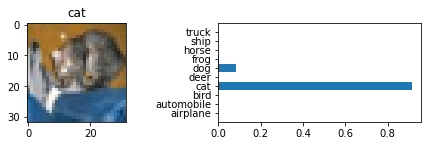

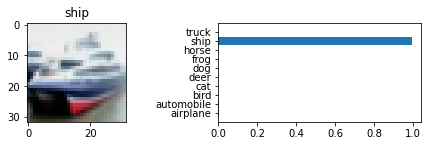

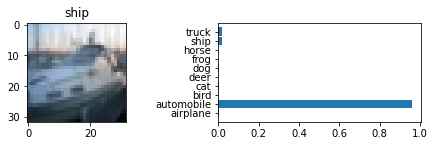

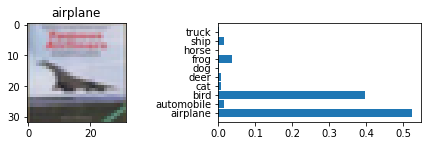

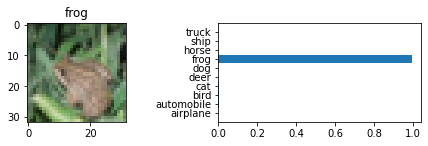

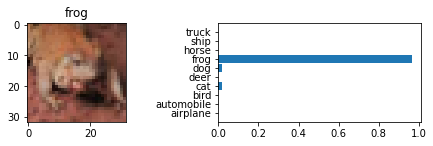

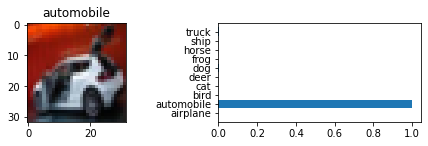

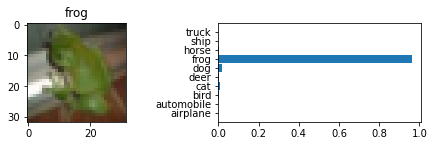

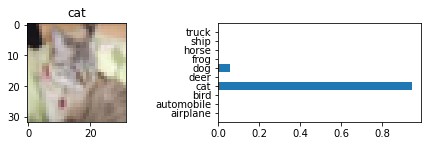

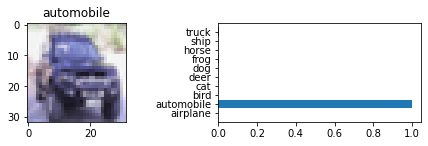

In [12]:
#Show 10 examples with the true label and the probablities of the predicted labels.
slen = 10
res = best_model.predict(X_test[:slen])
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for i in range(slen):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(2, 2, 1)
    plt.imshow(X_test_raw[i])
    class_name = class_names[y_test_raw[i][0]]
    plt.title(class_name)
    
    plt.subplot(2, 2, 2)
    y_pos = np.linspace(0, 1, len(class_names))
    plt.barh(y_pos, width=res[i], height=0.1)
    plt.yticks(y_pos, class_names)
    
    plt.show()